In [36]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import mlflow
import warnings


In [37]:
RANDOM_SEED = 42

# current_dir = os.path.dirname(os.path.realpath(__file__))
current_dir = os.getcwd()
data_fldr = os.path.join(current_dir, "..", "data")
out_dir = os.path.join(current_dir, "..", "data", "output")

coe_df = pd.read_excel(os.path.join(data_fldr, "COE_Export.xlsx"), sheet_name="Quarterly")

In [38]:
coe_df

,Month of Bidding Exercise,Bidding,Category,Statistic,Value,Year
0,2024-05-01,1,A,Quota Premium,93604,2024
1,2024-05-01,1,B,Quota Premium,105002,2024
2,2024-05-01,1,C,Quota Premium,70001,2024
3,2024-05-01,1,D,Quota Premium,9503,2024
4,2024-05-01,1,E,Quota Premium,104689,2024
...,...,...,...,...,...,...
2895,2005-08-15,2,E,Quota Premium,16296,2005
2896,2005-09-15,2,E,Quota Premium,15699,2005
2897,2005-10-15,2,E,Quota Premium,14503,2005
2898,2005-11-15,2,E,Quota Premium,14505,2005


In [39]:
coe_df_a = coe_df.loc[coe_df['Category'] == "A", :].sort_values(by='Month of Bidding Exercise')
coe_df_a

,Month of Bidding Exercise,Bidding,Category,Statistic,Value,Year
1748,2000-01-01,1,A,Quota Premium,43802,2000
1808,2000-01-15,2,A,Quota Premium,43802,2000
1749,2000-02-01,1,A,Quota Premium,43998,2000
1809,2000-02-15,2,A,Quota Premium,43998,2000
1750,2000-03-01,1,A,Quota Premium,39300,2000
...,...,...,...,...,...,...
860,2024-03-15,2,A,Quota Premium,85489,2024
5,2024-04-01,1,A,Quota Premium,89000,2024
855,2024-04-15,2,A,Quota Premium,94010,2024
0,2024-05-01,1,A,Quota Premium,93604,2024


In [99]:
# Split data into train and test sets
coe_df_set = coe_df_a.loc[:, ['Month of Bidding Exercise', 'Value']]
coe_df_set.set_index('Month of Bidding Exercise', inplace=True)
train_size = int(len(coe_df_set) * 0.90)
train, test = coe_df_set.iloc[:train_size], coe_df_set.iloc[train_size:]

train

,Value
Month of Bidding Exercise,
2000-01-01,43802
2000-01-15,43802
2000-02-01,43998
2000-02-15,43998
2000-03-01,39300
...,...
2021-10-15,52709
2021-11-01,53709
2021-11-15,55001


In [100]:
best_mse = float('inf')
best_params = None

# Define parameter grid
trend_types = [None, "add", "mul", "additive", "multiplicative"]
seasonal_periods = [2, 4, 6, 12, 24, 32]  # Example: Monthly, quarterly, half-yearly, yearly
seasonal_types = [None, "add", "mul", "additive", "multiplicative"]  # Additive or multiplicative

for t_type in trend_types:
    for period in seasonal_periods:
        for s_type in seasonal_types:
            print(f"Combination : Trend Type = {t_type}, Period = {period}, Seasonal Type = {s_type}")
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = ExponentialSmoothing(train['Value'],trend=t_type, seasonal=s_type, seasonal_periods=period)
                    fitted_model = model.fit()

                    # Forecast using fitted model
                    forecast = fitted_model.forecast(steps=len(test))

                    # Calculate MSE
                    mse = mean_squared_error(test['Value'], forecast)

                    # Track best parameters
                    if mse < best_mse:
                        best_mse = mse
                        best_params = (t_type, period, s_type)
            except:
                Warning("Exception Raised: Continuing")
                continue

print(f"Best parameters:Trend Type = {best_params[0]}, Seasonal periods = {best_params[1]}, Seasonal type = {best_params[2]}")
print(f"Best MSE: {best_mse}")


Combination : Trend Type = None, Period = 2, Seasonal Type = None
Combination : Trend Type = None, Period = 2, Seasonal Type = add
Combination : Trend Type = None, Period = 2, Seasonal Type = mul
Combination : Trend Type = None, Period = 2, Seasonal Type = additive
Combination : Trend Type = None, Period = 2, Seasonal Type = multiplicative
Combination : Trend Type = None, Period = 4, Seasonal Type = None
Combination : Trend Type = None, Period = 4, Seasonal Type = add
Combination : Trend Type = None, Period = 4, Seasonal Type = mul
Combination : Trend Type = None, Period = 4, Seasonal Type = additive
Combination : Trend Type = None, Period = 4, Seasonal Type = multiplicative
Combination : Trend Type = None, Period = 6, Seasonal Type = None
Combination : Trend Type = None, Period = 6, Seasonal Type = add
Combination : Trend Type = None, Period = 6, Seasonal Type = mul
Combination : Trend Type = None, Period = 6, Seasonal Type = additive
Combination : Trend Type = None, Period = 6, Seaso

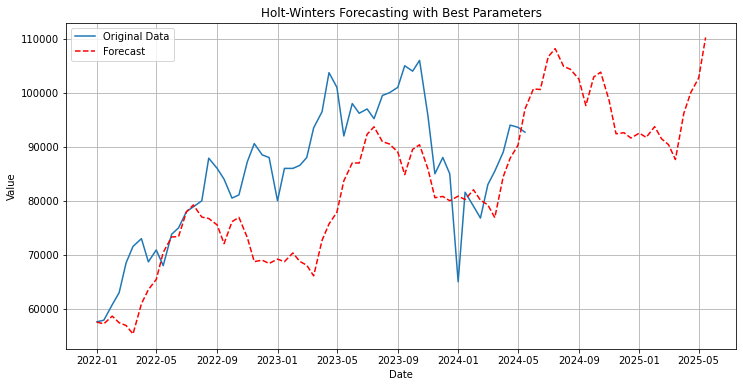

In [101]:
# Fit model with best parameters
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    best_model = ExponentialSmoothing(train, trend = best_params[0], seasonal=best_params[2], seasonal_periods=best_params[1])
    fitted_best_model = best_model.fit()

    # Forecast
    forecast_steps = len(test) + 24
    forecast_best = fitted_best_model.forecast(steps=forecast_steps)

# +1 due to starting offset
# print(pd.date_range(start = train.index[-1], periods=forecast_steps+1, freq="SMS"))

# Plot the data and forecast
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(test.index, test['Value'], label='Original Data')
plt.plot(pd.date_range(start = train.index[-1], periods=forecast_steps+1, freq="SMS")[1:], forecast_best, label='Forecast', linestyle='--', color='r')
plt.title('Holt-Winters Forecasting with Best Parameters')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
